## Tópicos Especiais em Inteligência Artificial
### Classificação de diagnóstico de câncer de mama com *Deep Neural Network (DNN)*

Neste trabalho vamos utilizar o dataset *Breast Cancer Wisconsin (Diagnostic)*, disponível no repositório de datasets da UCI. Este é um conjunto de dados multivalorado com atributos numericos de ponto-flutuante usado para classificação do tipo de câncer de mama de um paciente com *Malígno* ou *Benígno*. O dataset mostra os resultados de exames de 699 pacientes coletados entre 1989 e 1991. É composto de 11 atributos que são usados como entrada no modelo:

1. ID do paciente
2. Espessura (1-10)
3. Uniformidade de tamanho da célula (1-10)
4. Uniformidade de forma da célula (1-10)
5. Adesão marginal
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de núcleos normais (1-10)
10. Mitoses (1-10)
[SAÍDA] 11. Classificação (2 para indicar BENIGNO, 4 para indicar MALIGNO)

O dataset contém 458 amostras com 
- 65.5% de casos BENÍGNOS
- 34.5% de casos MALÍGNOS

---
Função para deixar o jupyter com celular preenchendo a tela toda

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 100% !important;}</style>"))

#importacao de bibliotecas

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import subprocess
import sys

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#utilitario de GPU
# from numba import cuda

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd


c:\Users\luanc\anaconda3\envs\dl_tf\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.10.19)
Hello from the pygame community. https://www.pygame.org/contribute.html



In [2]:
import keras
import tensorflow as tf
print('tensorflow: ', tf.__version__)
print('Keras: ', keras.__version__)
print('GPU disponivel: ', len(tf.config.list_physical_devices('GPU'))>0)
print('GPUs: ', tf.config.list_physical_devices('GPU'))

tensorflow:  2.15.0
Keras:  2.15.0
GPU disponivel:  False
GPUs:  []


In [3]:
#rotina de exportção da lista de pacotes
# def exporta_Requirements():
#    try:
#       resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'],
#       capture_output = True,
#       text = True,
#       check = True)
      
#       with open('requirements.txt', 'w') as f:
#          f.write(resultado.stdout)
#       print('Arquivo exportado com sucesso')
#    except subprocess.CalledProcessError as e:
#       print(f'Deu erro: {e}')
      
# exporta_Requirements()

### 2. Iportação do dataset

In [4]:
#2 benigno 4 maligno
# cria um nome pra cada coluna do dataset
col_names = ['ID', 'expessura', 'tam_celula',
            'form_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina',
            'nucleos_normais', 'mitoses', 'diagnostico']

#importacao do dataset
data = pd.read_csv('datasets/breast-cancer-wisconsin(in).csv', header=None, names=col_names)
#remove a coluna id pq ela nao serve pra nada
data = data.drop('ID', axis=1) #se for 0 é linha se for 1 é coluna

#substitui '?' um campo por NaN
data = data.replace('?', np.nan)

#converte tudo para o numero
data = data.astype(float)

#converte o codigo do diagnostico
data = data.assign(diagnostico=data['diagnostico'].replace({2:0, 4:1}))

#nomea as entradas e saidas
x_names = data.columns[:-1].tolist()
y_names = data.columns[-1:].tolist()

### 3. Configurações do Experimento

In [5]:
#realizar interpolação de dados - GERAÇÃO DE DADOS SINTÉTICOS
interpo_exec = True

#realizar deteccao e substituicao de outliers
outliers_exec = True

#realizar normalização de dados
normalization_exec = True

#metodo realizar escalonamento de dados
scale_exec = True

#exportar os datasets
export_frames = True

# gerar um novo modelo ou usar um pronto
new_model = True

### 4. Análise de Dados

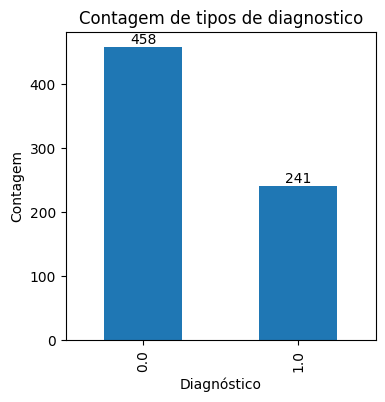

In [6]:
#contagem de diagnosticos
diag_counts = data['diagnostico'].value_counts()

#plota grafico de barra

plt.figure(figsize=(4,4))
diag_counts.plot(kind='bar')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.title('Contagem de tipos de diagnostico')

#adiciona rotulos
for i, count in enumerate(diag_counts):
   plt.text(i, count, str(count), ha='center', va='bottom')

#### 4.1. Sumarização estatística

In [7]:
def sumarizacao(data):
   stats = []
   for column in x_names:
      values = data[column]
      
      maximum = round(values.max(), 2)
      minimum = round(values.min(), 2)
      mean = round(values.mean(), 2)
      median = round(values.median(), 2)
      std = round(values.std(), 2)
      
      stats.append([column, maximum, minimum, mean, median, std])
      
   headers = ['Coluna', 'Máximo', 'Mínimo', 'Media', 'Mediana', 'Desvio Padrão']

   table = tabulate(stats, headers, tablefmt='pipe')
   print(table)
sumarizacao(data)

| Coluna          |   Máximo |   Mínimo |   Media |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| expessura       |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
| form_celula     |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus     |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina       |       10 |        1 |    3.44 |         3 |            2.44 |
| nucleos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses         |       10 |        1 |    1.59 |         1 |            1.72 |


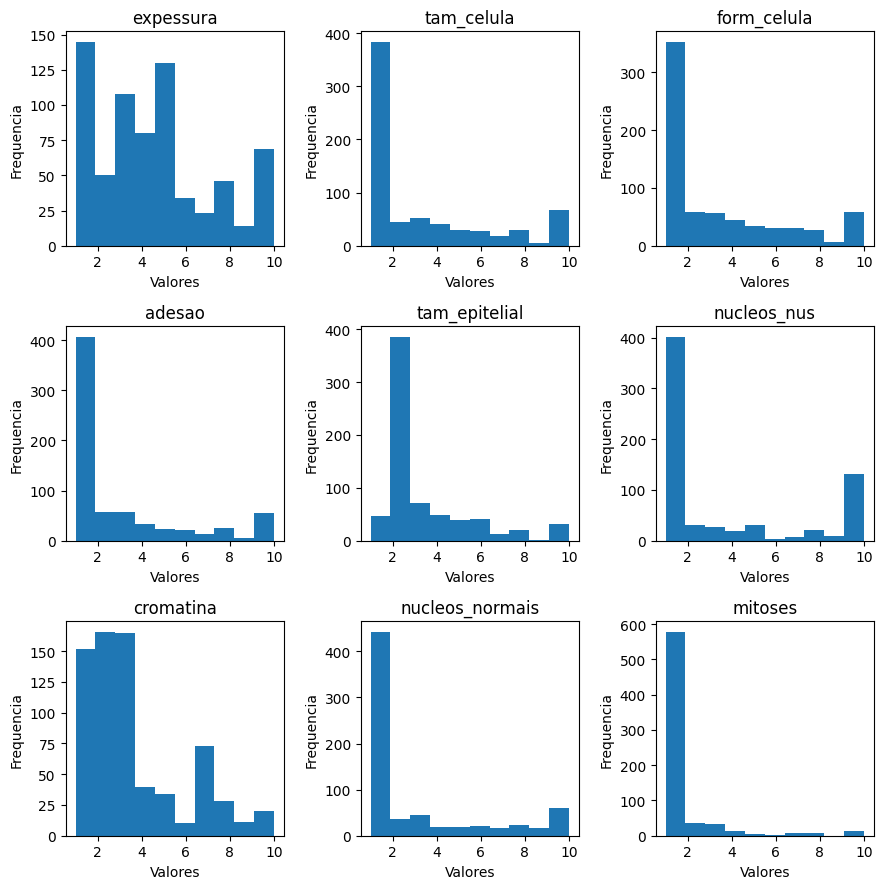

In [8]:
fig, axs = plt.subplots(3,3,figsize=(9,9), tight_layout=True)

for i, column in enumerate(x_names):
   row = i // 3 #linha atual
   col = i % 3 #coluna atual
   axs[row, col].hist(data[column], bins=10)
   axs[row, col].set_title(column)
   axs[row, col].set_xlabel('Valores')
   axs[row, col].set_ylabel('Frequencia')
   
plt.show()
   

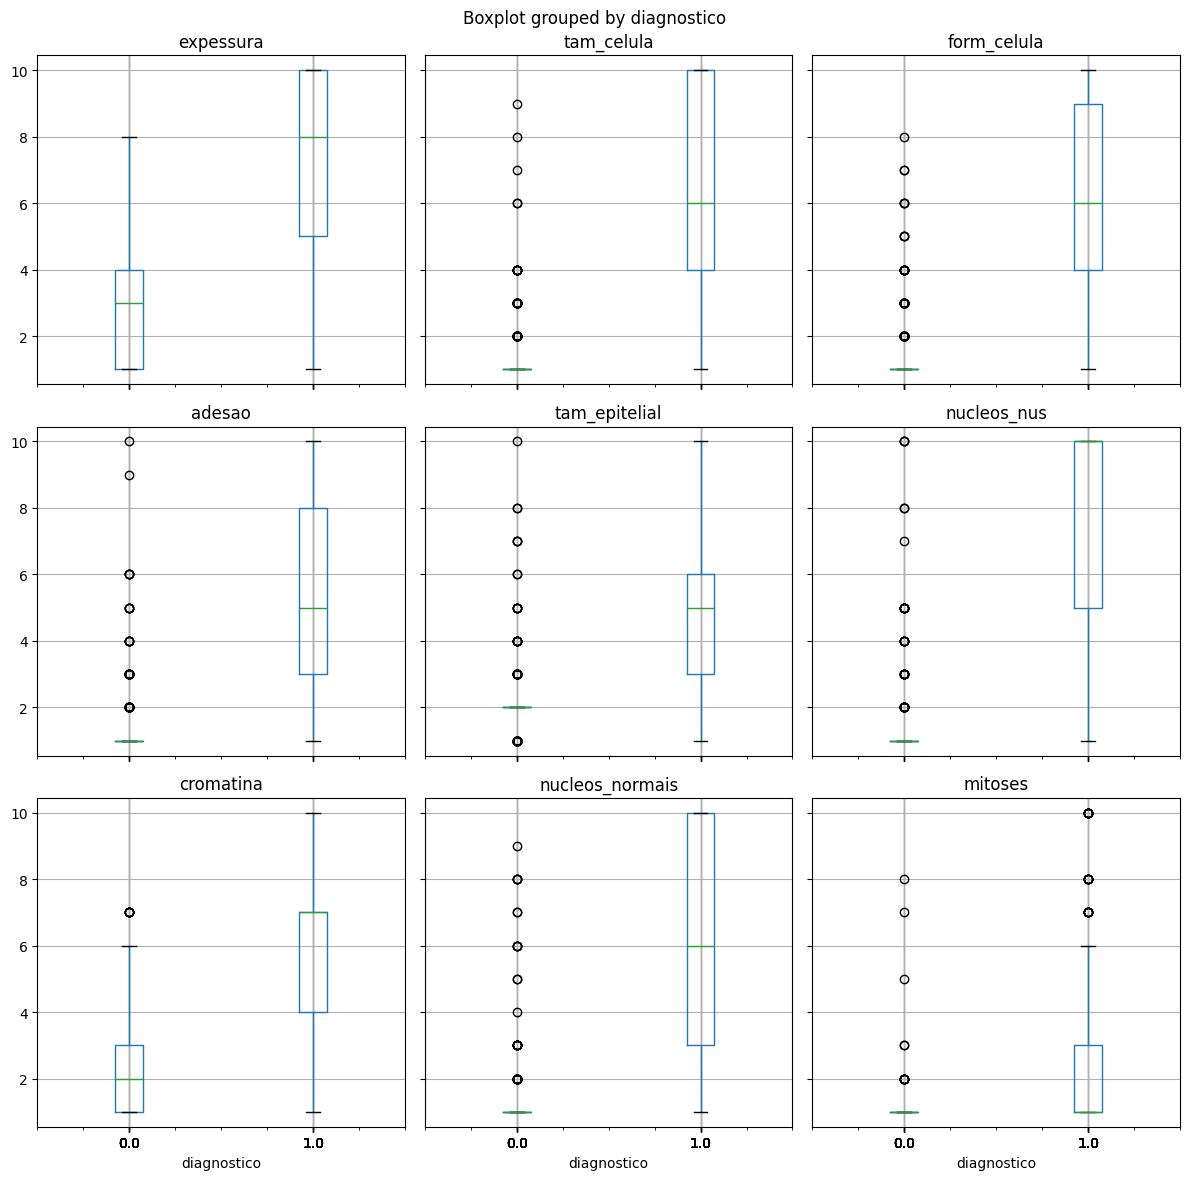

In [14]:
data.boxplot(column=x_names, by='diagnostico', figsize=(12, 12))
plt.tight_layout()
plt.show()